# Climate 485 Final Project 

In [1]:
### IMPORTS ###
import numpy as np
import matplotlib.pyplot as plt
from ocean_reflectance import ocean_R
import processing_fns as pfs
from IPython.display import Image

In [2]:
## NICE FORMATTING FUNCTION ##
def bold_axes(ax):
    """
    Sets matplotlib axes linewidths to 2, making them
    bold and more attractive

    Parameters
    -----------
    ax : mpl.Axes
        axes to be bolded
    """
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

    # increase tick width
    ax.tick_params(width=2)
    
    for label in ax.get_xticklabels():
        label.set_weight('bold')
        label.set_fontsize(12)

    for label in ax.get_yticklabels():
        label.set_weight('bold')
        label.set_fontsize(12)

In [3]:
## CONSTANTS FOR PLOTTING ##
IBM_YELLOW = "#ffb000"
IBM_ORANGE = "#fe6100"
IBM_PINK = "#dc267f"
IBM_PURPLE = "#785ef0"
IBM_BLUE = "#648fff"

IBM_CMAP = [IBM_YELLOW, IBM_ORANGE, IBM_PINK, IBM_PURPLE, IBM_BLUE]

In [4]:
COLOR_CLEAR = IBM_BLUE
COLOR_LE = IBM_PINK
COLOR_MCS = IBM_ORANGE

In [5]:
## LOAD IN DATA ##
df_liq_water = pfs.read_text_file("liquid_cloud_ka_0degC.txt", col_names = ['freq_GHz', 'mass_abs'])
df_wv_gases = pfs.read_text_file("mw_gas_absorption.txt", col_names = ['freq_GHz', 'dry_air_tau', 'wv_abs'])

/Users/laratobias-tarsh/Documents/wn25/clim485/project/processing_fns.py:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/Users/laratobias-tarsh/Documents/wn25/clim485/project/processing_fns.py:48: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [6]:
df_wv_gases

,freq_GHz,dry_air_tau,wv_abs
0,5.005,0.026761,0.000244
1,5.015,0.026714,0.000248
2,5.025,0.026668,0.000252
3,5.035,0.026621,0.000255
4,5.045,0.026574,0.000259
...,...,...,...
19495,199.955,0.059157,0.036685
19496,199.965,0.059163,0.036658
19497,199.975,0.059171,0.036631
19498,199.985,0.059180,0.036605


In [7]:
## CONSTANTS FOR EACH CASE##
T_CLOUD = 0 + 273.15 # Use bc mass extinction coefficient were at 0C, convert to K

LST_WINTER = 3       # lake surface temperature for winter in degrees C
LST_SUMMER = 10      # lake surface temperature for summer in degrees C
DELTA_LST = 1        # delta for central differencing

LWP_LE = 0.1           # cloud liquid water path in kg/m^2 for a lake effect cloud
LWP_MCS = 3            # cloud liquid water path in kg/m^2 for an MCS
DELTA_LWP = 0.01      # delta for central differencing

NEDT = 0.3           # NEDT for the sensor
TCWV = 14            # total column water vapor for a US standard atmosphere kg/m^2

FREQS = np.array(df_wv_gases.freq_GHz) # frequencies over which to plot

In [8]:
## SET KEY CONSTANTS ##
T_STAR_CLEAR = pfs.total_atmospheric_trans(FREQS, 0, df_liq_water, df_wv_gases, theta=0)
T_STAR_CLD_LE = pfs.total_atmospheric_trans(FREQS, LWP_LE, df_liq_water, df_wv_gases, theta=0)
T_STAR_CLD_MCS = pfs.total_atmospheric_trans(FREQS, LWP_MCS, df_liq_water, df_wv_gases)

In [9]:
LIST_TSTAR = [T_STAR_CLEAR,T_STAR_CLD_LE,T_STAR_CLD_MCS]
LIST_LWP = [0,LWP_LE,LWP_MCS]
LIST_COLOR = [COLOR_CLEAR,COLOR_LE,COLOR_MCS]
LIST_NAME = [r'Clear Sky ($\mathbf{0 kgm^{-2}}$)',r'Lake Effect Cloud ($\mathbf{0.1 kgm^{-2}}$)',r'MCS ($\mathbf{3 kgm^{-2}}$)']

## U.S. Standard Atmosphere Transmittance
Here we explore the uncertainties over a range of frequencies for a clear sky (no cloud atmosphere)
* Plot transmittance over frequency
* Identify the regions with the highest transmission

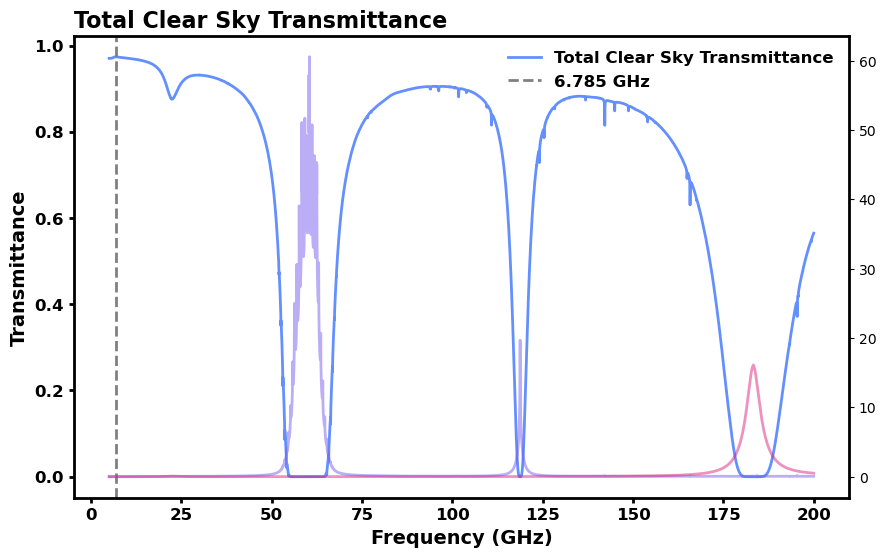

In [10]:
## PLOT CLEAR SKY TRANSMITTANCE AS A FUNCTION OF FREQUENCY
fig1, ax1 = plt.subplots(1,1, figsize = (10,6))
freq_of_max_t = FREQS[np.argmax(T_STAR_CLEAR)]

ax1.plot(FREQS, T_STAR_CLEAR,lw=2,c=IBM_BLUE,label='Total Clear Sky Transmittance')
ax1b = ax1.twinx()
ax1b.plot(FREQS, df_wv_gases.dry_air_tau, lw=2, alpha=0.5, c=IBM_PURPLE, label='Dry Air Optical Depth')
ax1b.plot(FREQS, df_wv_gases.wv_abs * TCWV, lw=2, alpha=0.5, c=IBM_PINK, label='Total Column WV Optical Depth')

ax1.axvline(freq_of_max_t, c = 'grey', ls = '--', label = f'{freq_of_max_t} GHz', lw=2)

ax1.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax1.set_ylabel("Transmittance",fontweight='bold',fontsize=14)
ax1.set_title("Total Clear Sky Transmittance",fontweight='bold',fontsize=16,loc='left')


# fix twinx formatting later
ax1.legend(frameon=False,prop={'weight':'bold','size':12})
bold_axes(ax1)

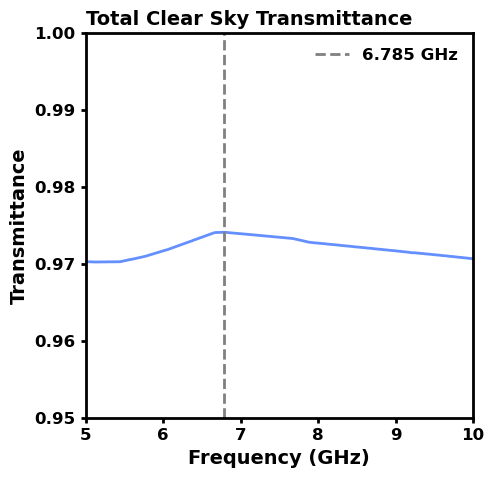

In [11]:
# Zooming into the frequency range with the highest transmittance
fig2, ax2 = plt.subplots(1,1, figsize = (5,5))

ax2.plot(FREQS, T_STAR_CLEAR,c=IBM_BLUE,lw=2)
ax2.axvline(freq_of_max_t, c = 'grey', ls = '--', label = f'{freq_of_max_t} GHz',lw=2)

ax2.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax2.set_ylabel("Transmittance",fontweight='bold',fontsize=14)
ax2.set_title("Total Clear Sky Transmittance",fontweight='bold',fontsize=14,loc='left')

ax2.set_xlim([5,10])
ax2.set_ylim([0.95,1])

ax2.legend(frameon=False,prop={'weight':'bold','size':12})
bold_axes(ax2)

Given the high atmospheric transmission around 6.8 GHz, this should lead to the lowest uncertainty in our measurement, at least for this component of the uncertainty. Nice thing is the amount of water vapor barely affects the transmission in this range.

# Lake-effect Cloud Example (LWP = 0.1 kg/m^2)
## Brightness Temperature of the Lake Surface

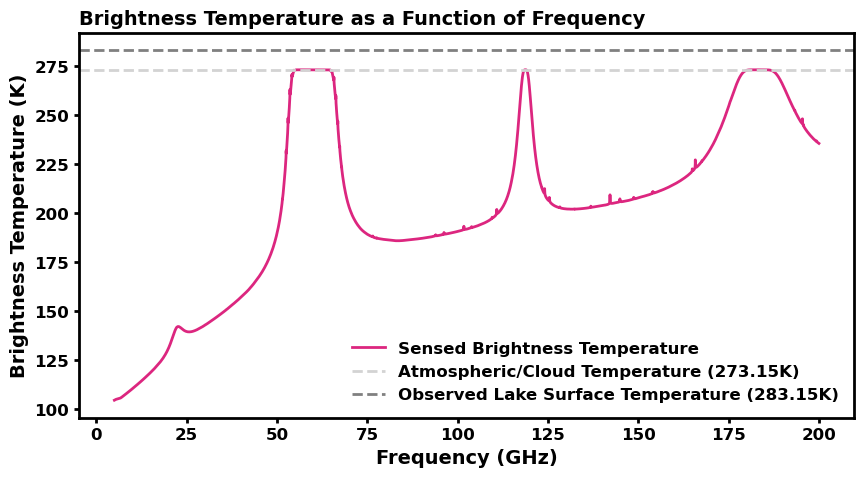

In [12]:
tb_Rv, tb_Rh = pfs.tb_polarization(LST_WINTER, FREQS, T_STAR_CLEAR, 273.15, theta=0)

fig3, ax3 = plt.subplots(1, 1, figsize = (10,5))
#ax3.plot(FREQS, tb_Rv, label = "Sensed Brightness Temperature Rv", lw=2, c=IBM_BLUE)
ax3.plot(FREQS, tb_Rh, label = "Sensed Brightness Temperature", lw=2, c=IBM_PINK)
ax3.axhline(273.15,lw='2',ls='--',c='lightgrey',label=f'Atmospheric/Cloud Temperature ({273.15}K)')
ax3.axhline(LST_SUMMER + 273.15,lw='2',ls='--',c='grey',label=f'Observed Lake Surface Temperature ({LST_SUMMER + 273.15}K)')

ax3.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax3.set_ylabel("Brightness Temperature (K)",fontweight='bold',fontsize=14)

ax3.set_title(f'Brightness Temperature as a Function of Frequency',fontweight='bold',fontsize=14,loc='left')
#ax3.set_title(f"LST: {LST_SUMMER + 273.15}K",fontweight='bold',fontsize=14,loc='right') replace with the estimated L

# add the crosses for the weighting function locations (6.875 GHz and at 60.435 GHz)
# add the weighting functions as a subplot here

bold_axes(ax3)
ax3.legend(frameon=False,prop={'weight':'bold','size':12})

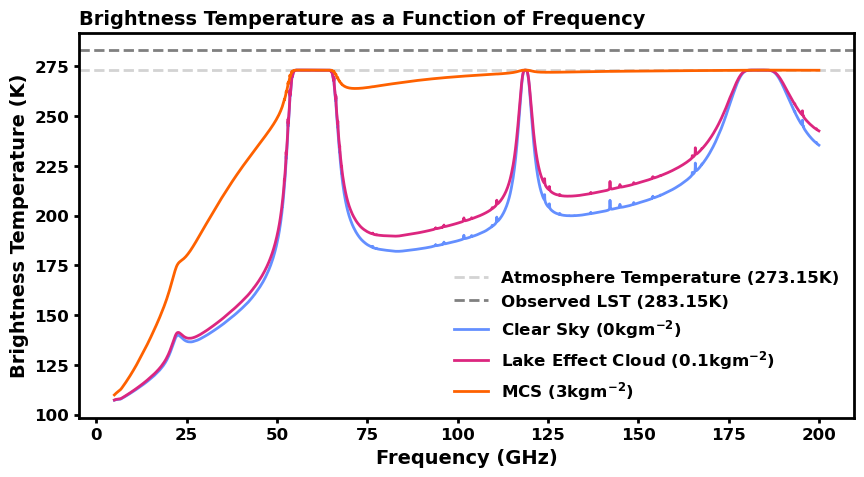

In [13]:
fig3, ax3 = plt.subplots(1, 1, figsize = (10,5))

ax3.axhline(273.15,lw='2',ls='--',c='lightgrey',label=f'Atmosphere Temperature ({273.15}K)')
ax3.axhline(LST_SUMMER + 273.15,lw='2',ls='--',c='grey',label=f'Observed LST ({LST_SUMMER + 273.15}K)')

for tstar,color,lab in zip(LIST_TSTAR,LIST_COLOR,LIST_NAME):
    tb_Rv, tb_Rh = pfs.tb_polarization(LST_SUMMER, FREQS, tstar, 273.15, theta=0)
    #ax3.plot(FREQS, tb_Rv, label = "Sensed Brightness Temperature Rv", lw=2, c=IBM_BLUE)
    ax3.plot(FREQS, tb_Rh, label = lab, lw=2, c=color)

    ax3.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
    ax3.set_ylabel("Brightness Temperature (K)",fontweight='bold',fontsize=14)

    ax3.set_title(f'Brightness Temperature as a Function of Frequency',fontweight='bold',fontsize=14,loc='left')
    #ax3.set_title(f"LST: {LST_SUMMER + 273.15}K",fontweight='bold',fontsize=14,loc='right') replace with the estimated L

    # add the crosses for the weighting function locations (6.875 GHz and at 60.435 GHz)
    # add the weighting functions as a subplot here


bold_axes(ax3)
ax3.legend(frameon=False,prop={'weight':'bold','size':12})

Both polarizations give the exact same brightness temperatures, probably because we have no salinity. Varying the lake surface temperature does not change the slope much, so the sensitivity shouldn't vary too much with temperature. Varying the cloud temperature doesn't change the slope at all (only moves the line up or down) because it is only a multiplicative factor and isn't part of ocean_R. I think varying the liquid water path has the largest effect because it's part of the exponential for transmittance. Brightness temperature shoots up in the oxygen absorption bands because the radiance is purely from the cloud top (Temp of 0C) where we are assuming the emissivity is one (?) .

## Total Uncertainty on LST

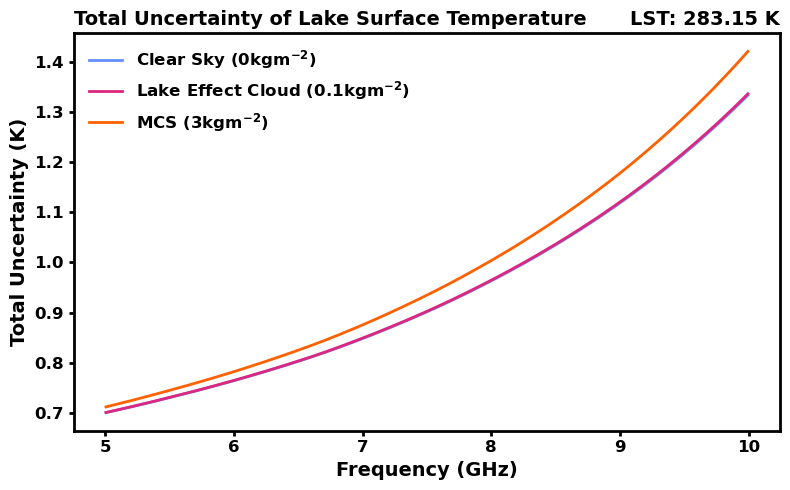

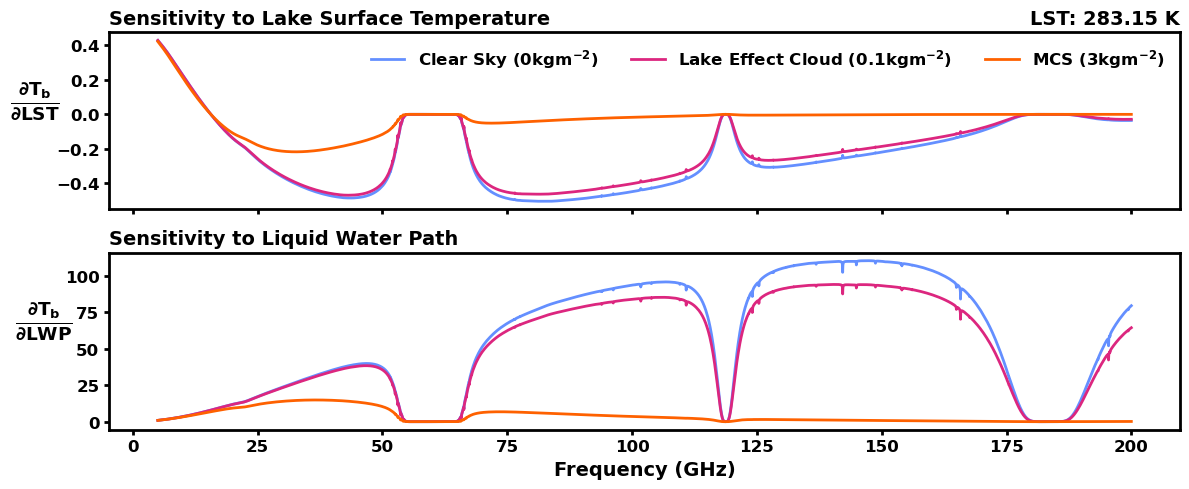

In [65]:
fig7, ax7 = plt.subplots(1, 1, figsize = (8,5))
fig8, (ax8a,ax8b) = plt.subplots(2, 1, figsize = (12,5),sharex=True)

for tstar, lwp, color, name in zip(LIST_TSTAR,LIST_LWP,LIST_COLOR,LIST_NAME):

    dtb_dlst_Rv, dtb_dlst_Rh = pfs.tb_sensitivity_lst(LST_SUMMER, DELTA_LST, FREQS, tstar)
    dtb_dlwp_Rv, dtb_dlwp_Rh = pfs.tb_sensitivity_lwp(LST_SUMMER, lwp, DELTA_LWP, FREQS, df_liq_water, df_wv_gases)

    ax8a.plot(FREQS, dtb_dlst_Rv,lw=2,c=color,label=name)
    ax8b.plot(FREQS, dtb_dlwp_Rv,lw=2,c=color,label=name)

    total_uncert = pfs.total_uncertainty(NEDT, dtb_dlst_Rv, dtb_dlwp_Rv, DELTA_LWP)

    ax7.plot(FREQS[:500], total_uncert[:500],lw=2,c=color,label=name)

    ax7.set_title("Total Uncertainty of Lake Surface Temperature",fontweight='bold',fontsize=14,loc='left')

    ax7.set_title(f"LST: {LST_SUMMER+273.15} K",fontweight='bold',fontsize=14,loc='right')

    ax7.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
    ax7.set_ylabel("Total Uncertainty (K)",fontweight='bold',fontsize=14)

bold_axes(ax7)
ax7.legend(frameon=False,prop={'weight':'bold','size':12})

[bold_axes(ax) for ax in [ax8a,ax8b]]
ax8a.legend(frameon=False,prop={'weight':'bold','size':12},ncols=3)

ax8b.set_xlabel("Frequency (GHz)",fontweight='bold',fontsize=14)
ax8a.set_ylabel(r"$\mathbf{\frac{\partial T_b}{\partial LST}}$    ", 
                rotation = 0, fontsize = 19, fontweight='bold')

ax8b.set_ylabel(r"$\mathbf{\frac{\partial T_b}{\partial LWP}}$    ", 
                rotation = 0, fontsize = 19, fontweight='bold')

ax8a.set_title('Sensitivity to Lake Surface Temperature',fontweight='bold',fontsize=14,loc='left')
ax8b.set_title('Sensitivity to Liquid Water Path',fontweight='bold',fontsize=14,loc='left')
ax8a.set_title(f"LST: {LST_SUMMER+273.15} K",fontweight='bold',fontsize=14,loc='right')

fig7.tight_layout()
fig8.tight_layout()

The frequency associated with a 1K Uncertainty is 7.975 GHz, and the aperture diameter will be 3.3624466097080044 m


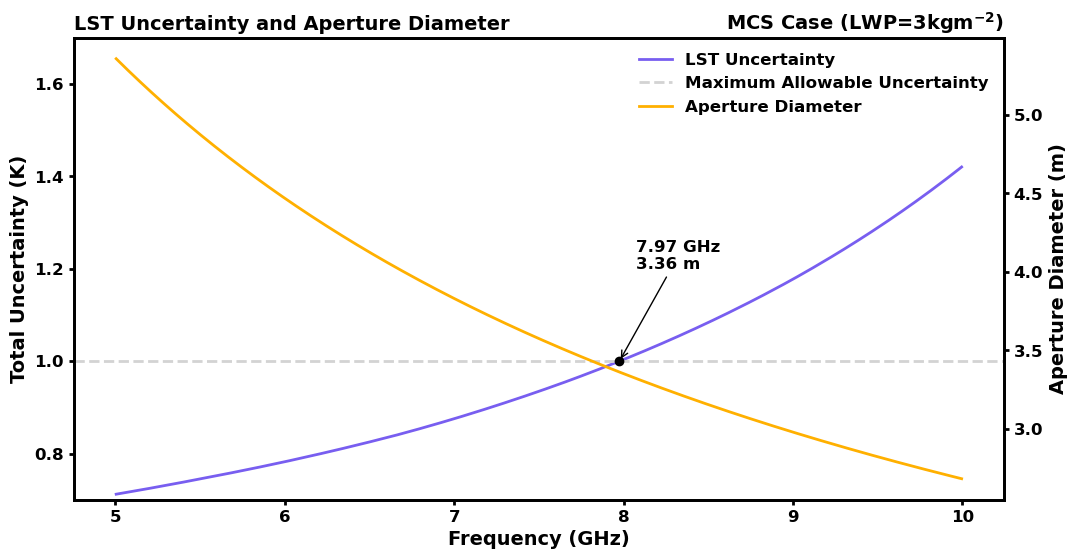

In [96]:
def aperture_uncert_comp(freqs, uncert, h=268341.167, dx=3000, c=2.99792e8):

    # Calculate aperture diameters as a function of frequency
    aperture_diam = c * h / (dx * freqs * 1e9)

    fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

    # Plot Uncertainty
    ax1.plot(freqs[:500], uncert[:500], label='LST Uncertainty', lw=2, c=IBM_PURPLE)
    ax1.set_xlabel('Frequency (GHz)', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Total Uncertainty (K)', fontweight='bold', fontsize=14)
    ax1.set_title('LST Uncertainty and Aperture Diameter', fontweight='bold', fontsize=14, loc='left')
    ax1.set_title('MCS Case (LWP=$\mathbf{3 kgm^{-2}}$)', fontweight='bold', fontsize=14, loc='right')

    # Plot aperture diameter
    ax2 = ax1.twinx()
    ax2.plot(freqs[:500], aperture_diam[:500], label="Aperture Diameter", lw=2, c=IBM_YELLOW)
    ax2.set_ylabel("Aperture Diameter (m)", fontweight='bold', fontsize=14)

    # Threshold line
    ax1.axhline(1, ls='--', label="Maximum Allowable Uncertainty", lw=2, c='lightgrey')


    # Annotate the point where uncertainty is closest to 1K
    x = freq_1K_uncert
    y = uncert[min_idx]
    diam = aperture_diam_1k_uncert

    ax1.plot(x, y, 'o', color='black')  # highlight the point
    ax1.annotate(f'{x:.2f} GHz\n{diam:.2f} m',
                 xy=(x, y),
                 xytext=(x+0.1, y+0.2),
                 arrowprops=dict(arrowstyle="->", color='black'),
                 fontsize=12,
                 fontweight='bold'
                 #bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white')
                 )


    # Bold axes
    bold_axes(ax1)
    bold_axes(ax2)
    ax1.set_ylim(0.7,1.7)

    # Combine and show legend from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, prop={'size':12,'weight':'bold'},frameon=False,ncols=1)

    return aperture_diam


aperture_diam = aperture_uncert_comp(FREQS, total_uncert)

# Get the index of the minimum absolute difference from 1K in the uncertainty array
uncert_diffs = np.abs(total_uncert[:500] - 1)
min_idx = np.argmin(uncert_diffs)

# Get the associated frequency and the aperture diameter
freq_1K_uncert = FREQS[min_idx]
aperture_diam_1k_uncert = aperture_diam[min_idx]

print(f"The frequency associated with a 1K Uncertainty is {freq_1K_uncert} GHz, and the aperture diameter will be {aperture_diam_1k_uncert} m")

In [ ]:
# Frequency with the lowest total uncertainty in the range plotted above
print('using argmin:')
freq_lowest_error = FREQS[np.argmin(total_uncert)]
print(f'idx: {np.argmin(total_uncert)}; freq: {freq_lowest_error}; value: {np.min(total_uncert)}')

print('using nanargmin:')
freq_lowest_error_nansafe = FREQS[np.nanargmin(total_uncert)]
print(f'idx: {np.nanargmin(total_uncert)}; freq: {freq_lowest_error_nansafe}; value: {np.nanmin(total_uncert)}')



using argmin:
idx: 5256; freq: 57.565; value: nan
using nanargmin:
idx: 0; freq: 5.005; value: 0.7119526352240497


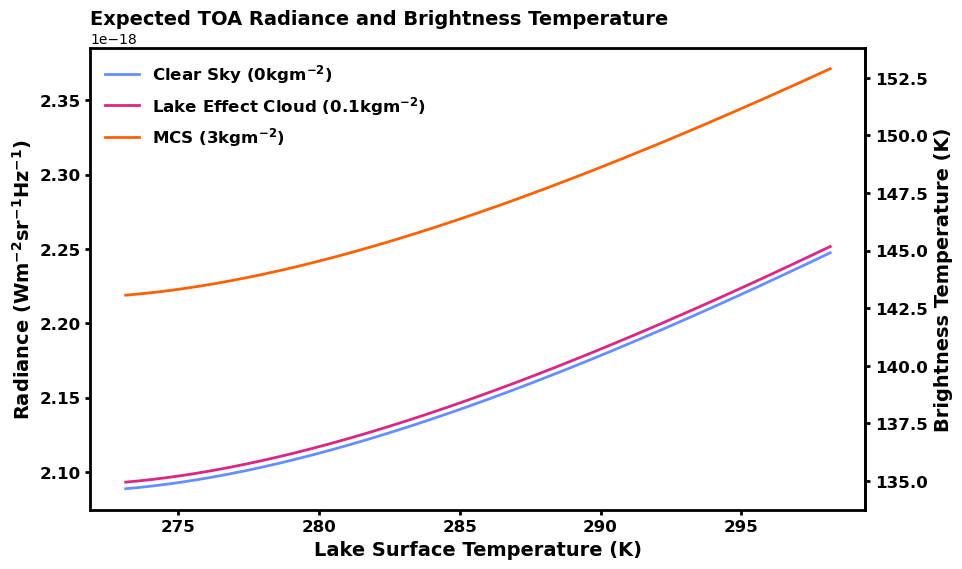

In [112]:
def radiance_fxn_lst(lst, freq, lwp, lss = 0, theta = 0, cloud_temp = 273.15):

    k = 1.380649*10**-23 # boltzmann constant
    c = 2.99792*10**8 # speed of light
   
    # Calculate the reflectances for the polarizations
    Rv, Rh = ocean_R(lst, lss, freq, theta)

    # Get the tramsmission at the wavelength
    t_star = pfs.total_atmospheric_trans(freq, lwp, df_liq_water, df_wv_gases, cwv = 14, theta = 0)

    radiance = ((1-Rv)*(lst+273.15)*t_star + (1-t_star)*cloud_temp)*2*(freq*10**9)**2*k/c**2

    return radiance

def radiance_to_tb(radiance, freq):
    # Convert radiance to brightness temperature
    k = 1.380649e-23  # Boltzmann constant
    c = 2.99792e8     # Speed of light
    freq_hz = freq * 1e9
    return radiance * c**2 / (2 * freq_hz**2 * k)

def tb_to_radiance(tb, freq):
    k = 1.380649e-23
    c = 2.99792e8
    freq_hz = freq * 1e9
    return tb * 2 * freq_hz**2 * k / c**2

lst = np.linspace(0, 25, 1000)  # 0 to 25 GHz
fig, ax = plt.subplots(1, 1, figsize = (10,6))

secax = ax.secondary_yaxis("right", functions=(lambda r: radiance_to_tb(r, 7.105),
                                               lambda tb: tb_to_radiance(tb, 7.105)))
secax.set_ylabel("Brightness Temperature (K)",fontweight='bold',fontsize=14)
bold_axes(secax)


for lwp, color, name in zip(LIST_LWP,LIST_COLOR,LIST_NAME):
    radiance = radiance_fxn_lst(lst, 7.97, lwp, lss = 0, theta = 0, cloud_temp = 273.15)
    ax.plot(lst+273.15, radiance,c=color,label=name,lw=2)
    ax.set_ylabel(r'Radiance ($\mathbf{Wm^{-2}sr^{-1}Hz^{-1}}$)',fontweight='bold',fontsize=14)
    ax.set_xlabel('Lake Surface Temperature (K)',fontweight='bold',fontsize=14)
    ax.set_title(f'Expected TOA Radiance and Brightness Temperature',fontweight='bold',fontsize=14,loc='left')
    ax.legend(prop={'size':12,'weight':'bold'},frameon=False,ncols=1)
    bold_axes(ax)


The frequency associated with the lowest uncertainty of 5.005 GHz makes sense because, based on the equation we derived for the uncertainty, we would expect the lowest where the sensitivity to the lake surface temperature is maximized and where the sensitivity to liquid water path is minimized. The above sensitivity plots verify that this is true. When I find the frequency associated with the lowest uncertainty over the whole frequency range, it's around 57 GHz. But when I zoomed in the see what it was actually doing, this is on the edge of that major absorption band, and I think the numbers were making it bug out to an unrealistic value. Ask him about this too.